# K Nearest Neighbors

## Imports

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import  StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import seaborn as sns

## Load data

In [26]:
df = pd.read_csv('data/dataset.csv')
df = df[df['genre'].notnull()]
df.head(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.0180,...,0.1760,0.797,101.801,213613,4,48.82510,10,0,60,pop
6,Samba De Uma Nota So (One Note Samba),Antônio Carlos Jobim,spotify:track:62eoocmGk59EMfuRcLBvUL,0.662,0.272,0,-18.883,1,0.0313,0.3600,...,0.0963,0.591,143.507,134360,4,47.82155,7,0,60,jazz
9,I Can Hear Music,The Beach Boys,spotify:track:1hcMfYTsRTC4hIKbfosxjz,0.511,0.603,2,-7.637,1,0.0280,0.0385,...,0.1420,0.685,128.336,157293,4,43.36534,9,1,60,pop
11,Ride Away,Roy Orbison,spotify:track:1nxSCulSg5AtmExqgHPPC0,0.520,0.411,9,-12.411,1,0.0315,0.7860,...,0.1460,0.350,120.290,207573,4,37.54527,9,1,60,pop
13,P.T. 109,Jimmy Dean,spotify:track:3vfNUZeVUiwWXwsEXjagqL,0.746,0.666,2,-10.408,1,0.1460,0.5430,...,0.0488,0.840,94.024,192427,4,78.59848,5,1,60,country


## Helper functions

In [42]:
def plot_heatmap(model, X_test, y_test, le_genre):
    y_predict = model.predict(X_test)
    conf_matrix_nb=pd.crosstab(
        le_genre.inverse_transform(y_test),
        le_genre.inverse_transform(y_predict),
        rownames=['Actual'],
        colnames=['Predicted']
    )
    sns.heatmap(conf_matrix_nb)

In [43]:
def encode_df(df, le_decade, le_genre):
    df_encoded = df[
        ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
         'instrumentalness', 'acousticness', 'liveness', 'valence', 'tempo',
         'duration_ms', 'chorus_hit', 'decade', 'genre']
    ].copy()
    df_encoded['n_decade'] = le_decade.transform(df_encoded['decade'])
    df_encoded['n_genre'] = le_genre.transform(df_encoded['genre'])
    df_encoded = df_encoded.drop(['genre', 'decade'], axis=1)
    return df_encoded

In [44]:
def split(df):
    return train_test_split(df.drop('n_genre', axis=1), df['n_genre'])

In [45]:
def fit_summary(model, df):
    le_decade = LabelEncoder()
    le_decade.fit(df.decade)
    le_genre = LabelEncoder()
    le_genre.fit(df.genre)
    df_encoded = encode_df(df, le_decade, le_genre)
    X_train, X_test, y_train, y_test = split(df_encoded)
    model.fit(X_train, y_train)
    plot_heatmap(model, X_test, y_test, le_genre)
    y_predict = model.predict(X_test)
    print(f'Model accuracy score: {model.score(X_test, y_test)}')
    dummy_model = DummyClassifier(strategy='most_frequent')
    dummy_model.fit(X_train, y_train)
    print(f'DummyClassifier accuracy score: {dummy_model.score(X_test, y_test)}')
    print(f'Confusion matrix: \n{confusion_matrix(y_test, y_predict)}')
    print(f'Classification report: \n{classification_report(y_test, y_predict)}')

In [46]:
def scale_df(df, scaler):
    scale_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                     'instrumentalness', 'acousticness', 'liveness', 'valence', 'tempo',
                     'duration_ms', 'chorus_hit']
    df_scaled = df.copy()
    df_scaled[scale_columns] = scaler.fit_transform(df[scale_columns])
    return df_scaled

In [47]:
def plot_validation_curve(estimator, x, y, *, param_name, param_range, cv):
    train_scores, test_scores = validation_curve(
        estimator, x, y, param_name=param_name, param_range=param_range, cv=cv
    )
    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    plt.figure(figsize=(20, 10))
    plt.title('Validation Curve for Decision Tree Classifier')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label='Training score',
                 color='darkorange', lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color='darkorange', lw=lw)
    plt.plot(param_range, test_scores_mean, label='Test score',
                 color='navy', lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color='navy', lw=lw)
    plt.xticks(param_range)
    plt.legend(loc='best')

## Classification

### Original data

#### Not scaled

Model accuracy score: 0.36064605081741186
DummyClassifier accuracy score: 0.36084301753003745
Confusion matrix: 
[[   0    2    1    0    7    0  104   21    0]
 [   0    6    0    4    0    0  408   76    0]
 [   0    2    6    3   17    3  152   69    0]
 [   0    5    0    3    2    0  299   86    0]
 [   0    1    4    0   44    3  211   75    0]
 [   0    1    2    0   21    3  152   57    0]
 [   0   15    4    5   17    0 1459  332    0]
 [   0    8    6    1   40    0  994  310    0]
 [   0    0    1    0    3    0   21   11    0]]
Classification report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       135
           1       0.15      0.01      0.02       494
           2       0.25      0.02      0.04       252
           3       0.19      0.01      0.01       395
           4       0.29      0.13      0.18       338
           5       0.33      0.01      0.02       236
           6       0.38      0.80      0.52      18

F:\Programs\Anaconda3\envs\py38_spotify-song-attributes-EDA\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


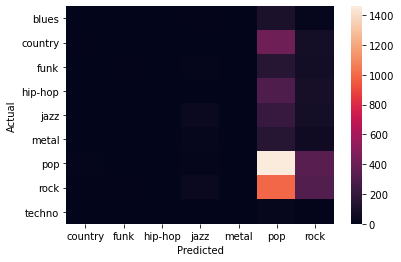

In [33]:
knn_classifier = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 40)}
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5)
fit_summary(knn_gscv, df)

In [34]:
knn_gscv.best_params_

{'n_neighbors': 37}

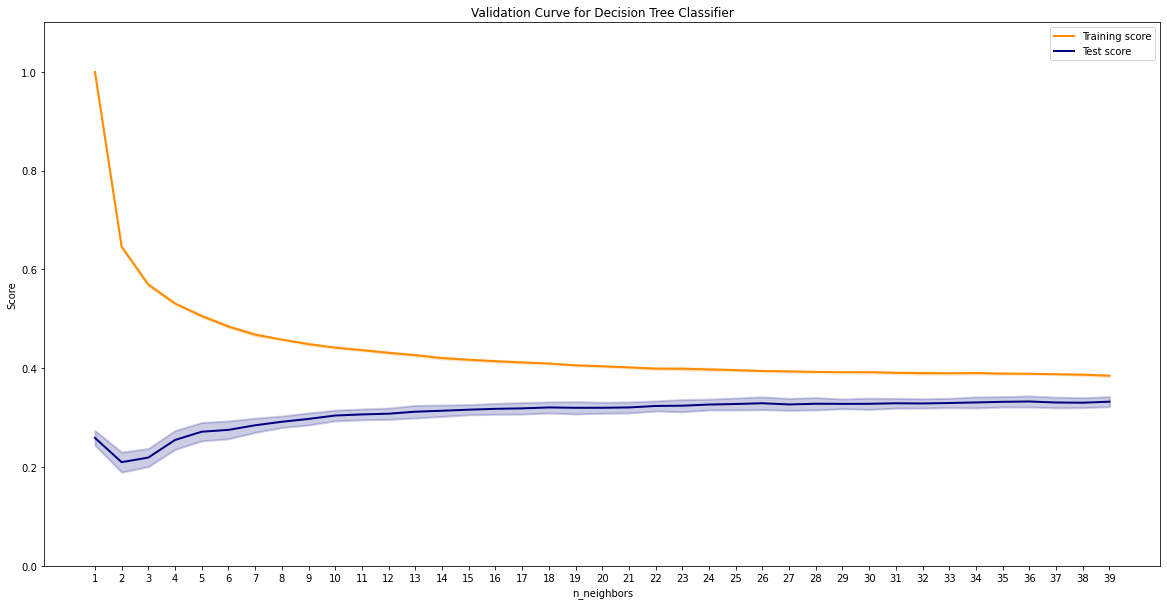

In [35]:
df_encoded = encode_df(df, LabelEncoder().fit(df.decade), LabelEncoder().fit(df.genre))
X_train, X_test, y_train, y_test = split(df_encoded)
plot_validation_curve(KNeighborsClassifier(),
                      df_encoded.drop(['n_genre'], axis=1),
                      df_encoded['n_genre'],
                      param_name='n_neighbors',
                      param_range=list(range(1, 40)),
                      cv=5)

From what we can see the n_neighbors parameter doesn't lead to overfitting

#### Scaled

In [36]:
df_scaled = scale_df(df, StandardScaler())

Model accuracy score: 0.5247193224345086
DummyClassifier accuracy score: 0.3594642505416585
Confusion matrix: 
[[   2    6    2    0   18    1   92   17    0]
 [   1  232    0    1    5    0  257   47    0]
 [   0    3   21    9    6    0  177   51    0]
 [   0   22    0  196    1    1  139    8    0]
 [   1   10    6    5  112    2  157   39    0]
 [   0    3    0    2    0  117    9   73    0]
 [   0  123    7   54   29   11 1297  304    0]
 [   2   77    8    6   24   27  528  686    0]
 [   0    0    0    3    7    4   19    9    1]]
Classification report: 
              precision    recall  f1-score   support

           0       0.33      0.01      0.03       138
           1       0.49      0.43      0.46       543
           2       0.48      0.08      0.14       267
           3       0.71      0.53      0.61       367
           4       0.55      0.34      0.42       332
           5       0.72      0.57      0.64       204
           6       0.48      0.71      0.58      1825

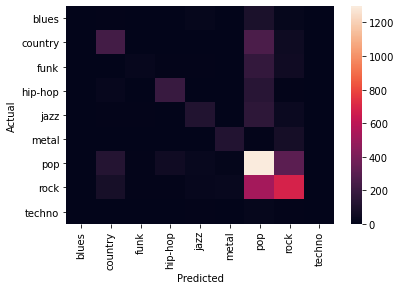

In [37]:
knn_classifier = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 40)}
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5)
fit_summary(knn_gscv, df_scaled)

In [38]:
knn_gscv.best_params_

{'n_neighbors': 35}

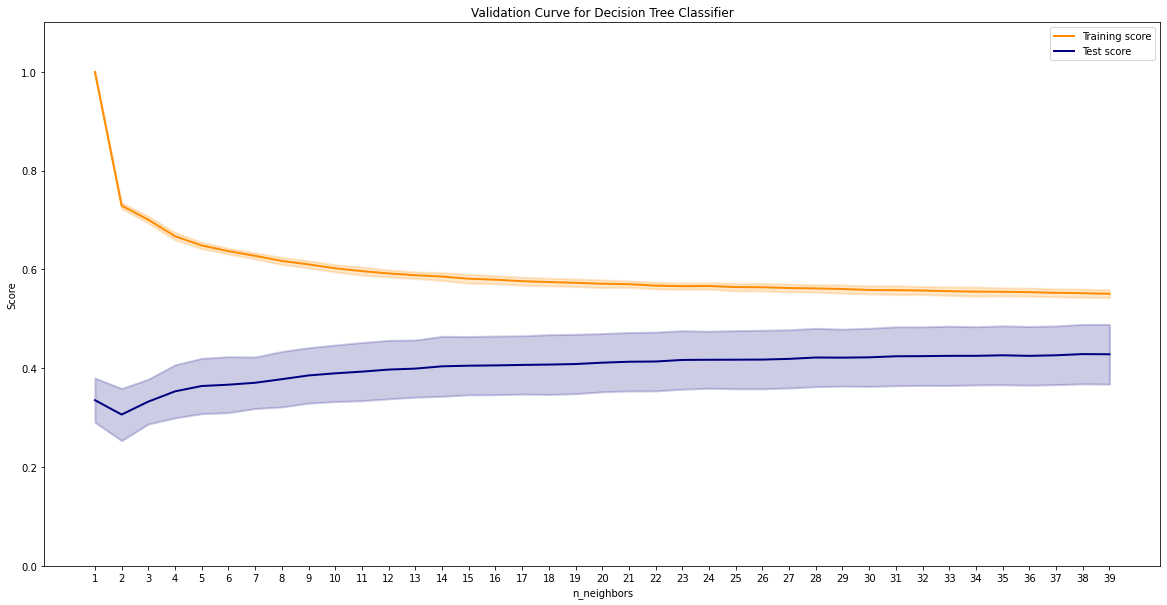

In [39]:
df_encoded = encode_df(df_scaled, LabelEncoder().fit(df_scaled.decade), LabelEncoder().fit(df_scaled.genre))
X_train, X_test, y_train, y_test = split(df_encoded)
plot_validation_curve(KNeighborsClassifier(),
                      df_encoded.drop(['n_genre'], axis=1),
                      df_encoded['n_genre'],
                      param_name='n_neighbors',
                      param_range=list(range(1, 40)),
                      cv=5)

### Upsampled classes data

In [48]:
df_upsampled_list = []
largest_class_count = max(df.genre.value_counts())
for i in np.unique(df.genre):
    tmp = resample(
        df[df.genre == i],
        replace=True,
        n_samples=largest_class_count,
        random_state=0
    )
    df_upsampled_list.append(tmp)
df_upsampled = pd.concat(df_upsampled_list)
df_upsampled = df_upsampled.sample(frac=1).reset_index(drop=True)
df_upsampled

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
0,Speed of Sound,Halford,spotify:track:13tpFBLQlnzAZekzV64LJL,0.378,0.938,9,-7.528,1,0.0828,0.000038,...,0.255,0.6740,174.887,271907,4,25.37805,11,0,0,metal
1,Bonfire,Craig Morgan,spotify:track:4PyKicaf5RL5tlidl6ZMO5,0.426,0.917,0,-2.968,1,0.1030,0.119000,...,0.153,0.5060,175.716,179707,4,28.69814,11,1,0,country
2,Honey Dove,Lee Fields & The Expressions,spotify:track:1emxi7e5EWFsJmwSKTuUDH,0.487,0.497,4,-5.776,0,0.0640,0.124000,...,0.109,0.1950,160.317,246573,4,44.78423,10,0,0,funk
3,"Yes, I'm Ready",Barbara Mason,spotify:track:2gZpW5pTZkimGG98loFSl2,0.237,0.377,5,-8.798,1,0.0287,0.902000,...,0.131,0.4790,173.142,184333,3,35.51402,10,1,60,funk
4,Mechanical Bull,Stella Donnelly,spotify:track:0BsYZCe5vuUHdmlcsOWSep,0.618,0.266,0,-6.675,0,0.0309,0.841000,...,0.106,0.0921,128.314,161249,4,23.00543,8,0,10,pop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64624,Money In The Bank,Swizz Beatz,spotify:track:6dRJV7zQ6S8BDdzMdV0MPW,0.837,0.697,0,-5.955,1,0.2990,0.010800,...,0.377,0.6310,97.927,191920,4,41.14749,13,1,0,hip-hop
64625,I Wanna Rock,Snoop Dogg,spotify:track:3vNiHPIipR4a4bZKA288CD,0.521,0.849,5,-3.238,1,0.3180,0.168000,...,0.289,0.4310,122.852,235987,5,25.07463,13,1,10,hip-hop
64626,Days Go By,Dirty Vegas,spotify:track:2RLpFEf6d0708O7Bqhjyxg,0.786,0.853,9,-8.274,0,0.0688,0.049900,...,0.350,0.3090,126.990,432147,4,18.48264,19,1,0,techno
64627,Mystic Eyes,Them,spotify:track:4jyTPINPO1Zc6an1zPWJTy,0.408,0.857,9,-7.334,1,0.0713,0.000076,...,0.151,0.4870,121.334,163453,4,29.05576,8,1,60,blues


<AxesSubplot:ylabel='genre'>

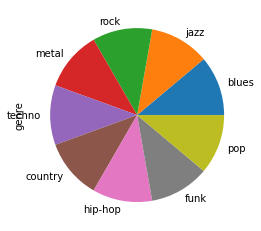

In [49]:
df_upsampled.genre.value_counts().plot.pie()

#### Not scaled

Model accuracy score: 0.9218343854437431
DummyClassifier accuracy score: 0.1065725956182696
Confusion matrix: 
[[1759    0    0    0    0    0    0    0    0]
 [   9 1697   11    7    6   10   64   31    0]
 [   0    0 1806    6    1    0    0    0    0]
 [   0    8    1 1774    6    6    5    8    0]
 [   4    5    8    3 1787    4    9    9    0]
 [   3    2    0    0    0 1807    0    0    0]
 [  26  112   48   74   83   33 1166  172    8]
 [  22   83   42   64   54   47  157 1285   12]
 [   0    0    0    0    0    0    0    0 1814]]
Classification report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1759
           1       0.89      0.92      0.91      1835
           2       0.94      1.00      0.97      1813
           3       0.92      0.98      0.95      1808
           4       0.92      0.98      0.95      1829
           5       0.95      1.00      0.97      1812
           6       0.83      0.68      0.75      1722

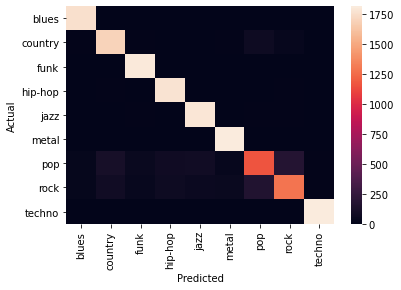

In [50]:
knn_classifier = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 40)}
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5)
fit_summary(knn_gscv, df_upsampled)

In [51]:
knn_gscv.best_params_

{'n_neighbors': 1}

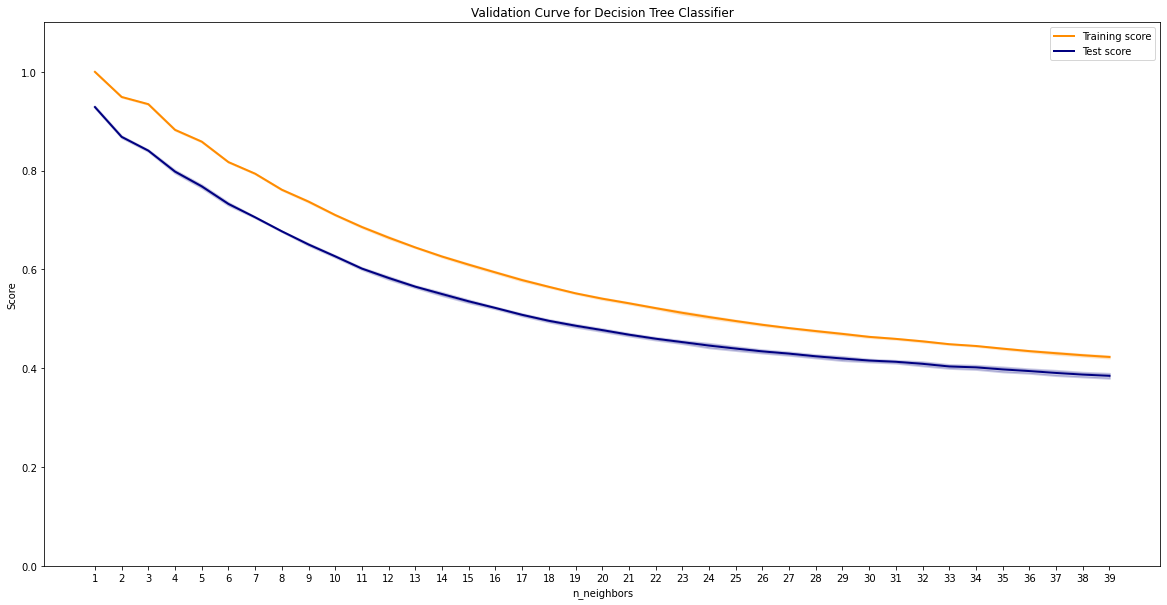

In [52]:
df_encoded = encode_df(df_upsampled, LabelEncoder().fit(df_upsampled.decade), LabelEncoder().fit(df_upsampled.genre))
X_train, X_test, y_train, y_test = split(df_encoded)
plot_validation_curve(KNeighborsClassifier(),
                      df_encoded.drop(['n_genre'], axis=1),
                      df_encoded['n_genre'],
                      param_name='n_neighbors',
                      param_range=list(range(1, 40)),
                      cv=5)

#### Scaled

In [53]:
df_upsampled_scaled = scale_df(df_upsampled, StandardScaler())

Model accuracy score: 0.9338408218838965
DummyClassifier accuracy score: 0.10737715063745513
Confusion matrix: 
[[1773    0    0    0    0    0    0    0    0]
 [   4 1672    2    2    8    2   26   19    0]
 [   0    0 1821    0    0    0    6    0    0]
 [   0    4    0 1778    0    0   13    0    2]
 [   0    2    0    0 1862    0   16    5    0]
 [   0    0    0    4    0 1773    0    4    1]
 [  32  139   63   53   48   22 1270  207    4]
 [  10   82   37   12   20   45  174 1403    1]
 [   0    0    0    0    0    0    0    0 1737]]
Classification report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1773
           1       0.88      0.96      0.92      1735
           2       0.95      1.00      0.97      1827
           3       0.96      0.99      0.98      1797
           4       0.96      0.99      0.97      1885
           5       0.96      0.99      0.98      1782
           6       0.84      0.69      0.76      183

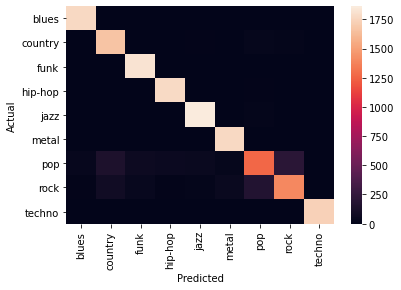

In [54]:
knn_classifier = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 40)}
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5)
fit_summary(knn_gscv, df_upsampled_scaled)

In [55]:
knn_gscv.best_params_

{'n_neighbors': 1}

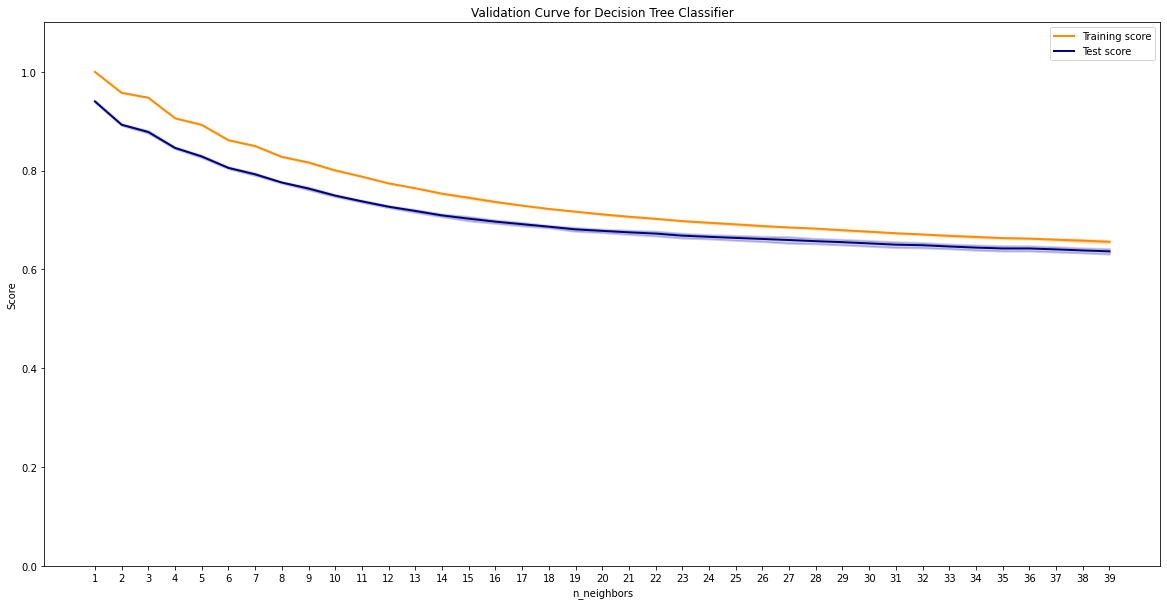

In [56]:
df_encoded = encode_df(df_upsampled_scaled, LabelEncoder().fit(df_upsampled_scaled.decade), LabelEncoder().fit(df_upsampled_scaled.genre))
X_train, X_test, y_train, y_test = split(df_encoded)
plot_validation_curve(KNeighborsClassifier(),
                      df_encoded.drop(['n_genre'], axis=1),
                      df_encoded['n_genre'],
                      param_name='n_neighbors',
                      param_range=list(range(1, 40)),
                      cv=5)

#### Conclusion

Upsampling this way is bad because it upsamples the whole dataset before it is split into train and test, resulting in the test set having a large overlap with the train set.  
A further test with an upsampled train set is required.

### Downsampled classes data

In [57]:
df_downsampled_list = []
smallest_class_count = min(df.genre.value_counts())
for i in np.unique(df.genre):
    tmp = resample(
        df[df.genre == i],
        replace=False,
        n_samples=smallest_class_count,
        random_state=0
    )
    df_downsampled_list.append(tmp)
df_downsampled = pd.concat(df_downsampled_list)
df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
df_downsampled

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade,genre
0,Built for Comfort,Taj Mahal,spotify:track:1VspMn4pxgoFZ98JzI4Q6d,0.553,0.355,7,-9.432,1,0.0437,0.750000,...,0.1030,0.329,140.702,297587,3,29.19043,13,0,70,blues
1,Brand New Car,Big Joe Williams,spotify:track:42HABEWDddELSjrDOjGFAq,0.501,0.328,4,-15.038,0,0.3110,0.727000,...,0.8840,0.484,94.020,332840,4,36.07710,17,0,70,blues
2,Rhesus Artificial,The Interbeing,spotify:track:0m6wzwyVy2kg3vWovrXRxb,0.460,0.950,7,-3.454,1,0.0848,0.000028,...,0.0741,0.197,90.003,271427,3,94.72718,7,0,10,metal
3,Tendency,Jan Jelinek,spotify:track:6Py6ERVoAbMCwQhTatlluh,0.751,0.468,6,-14.386,1,0.0481,0.593000,...,0.1110,0.469,123.014,441227,4,30.77718,17,0,0,techno
4,Keep On Dancing,Alvin Cash,spotify:track:4u8pvyvUdysYaD8cjXKtkU,0.784,0.709,2,-10.067,0,0.0552,0.366000,...,0.1170,0.962,123.346,162867,4,45.89170,9,1,60,funk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,"She's A Bad Mama Jama (She's Built, She's Stac...",Carl Carlton,spotify:track:7KEguG3CDoestm50v6XET5,0.879,0.581,0,-6.078,1,0.0723,0.117000,...,0.0435,0.629,114.226,234707,4,71.24014,9,1,80,funk
1454,Something in My Heart,Ricky Skaggs,spotify:track:1eAGoEQD211GAHSO846fC0,0.643,0.442,5,-9.222,1,0.0263,0.059300,...,0.1140,0.807,138.432,179840,4,48.16072,8,0,80,country
1455,"Jeeps, Lex Coups, Bimaz & Benz",Lost Boyz,spotify:track:02nH7HXbs3i9kdWef9or8E,0.562,0.652,1,-9.253,0,0.4260,0.010300,...,0.5570,0.545,177.987,272467,4,35.49160,12,1,90,hip-hop
1456,A.D.I.D.A.S.,Killer Mike Featuring Big Boi,spotify:track:4Ol9JFw2Icl79oTqH1sG4t,0.927,0.838,10,-2.741,0,0.2270,0.007930,...,0.4880,0.690,93.031,211400,4,43.10275,10,1,0,hip-hop


#### Not scaled

Model accuracy score: 0.1506849315068493
DummyClassifier accuracy score: 0.09315068493150686
Confusion matrix: 
[[10 10  1  6  2  2  0  0  4]
 [ 7 11  0  8  2  2  2  1  1]
 [ 7  9  2  5  4  6  1  1 11]
 [ 4 13  1  6  2  1  4  0  5]
 [ 5  6  4  3  9  5  0  0 11]
 [ 7  8  2 12  5  1  5  1  5]
 [10 11  2  7  4  3  5  0  1]
 [ 6 10  0  7  6  2  4  1  3]
 [ 2 12  1  3  8  3  2  2 10]]
Classification report: 
              precision    recall  f1-score   support

           0       0.17      0.29      0.22        35
           1       0.12      0.32      0.18        34
           2       0.15      0.04      0.07        46
           3       0.11      0.17      0.13        36
           4       0.21      0.21      0.21        43
           5       0.04      0.02      0.03        46
           6       0.22      0.12      0.15        43
           7       0.17      0.03      0.04        39
           8       0.20      0.23      0.21        43

    accuracy                           0.15       3

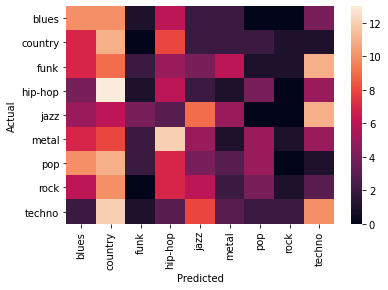

In [60]:
knn_classifier = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 40)}
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5)
fit_summary(knn_gscv, df_downsampled)

In [61]:
knn_gscv.best_params_

{'n_neighbors': 34}

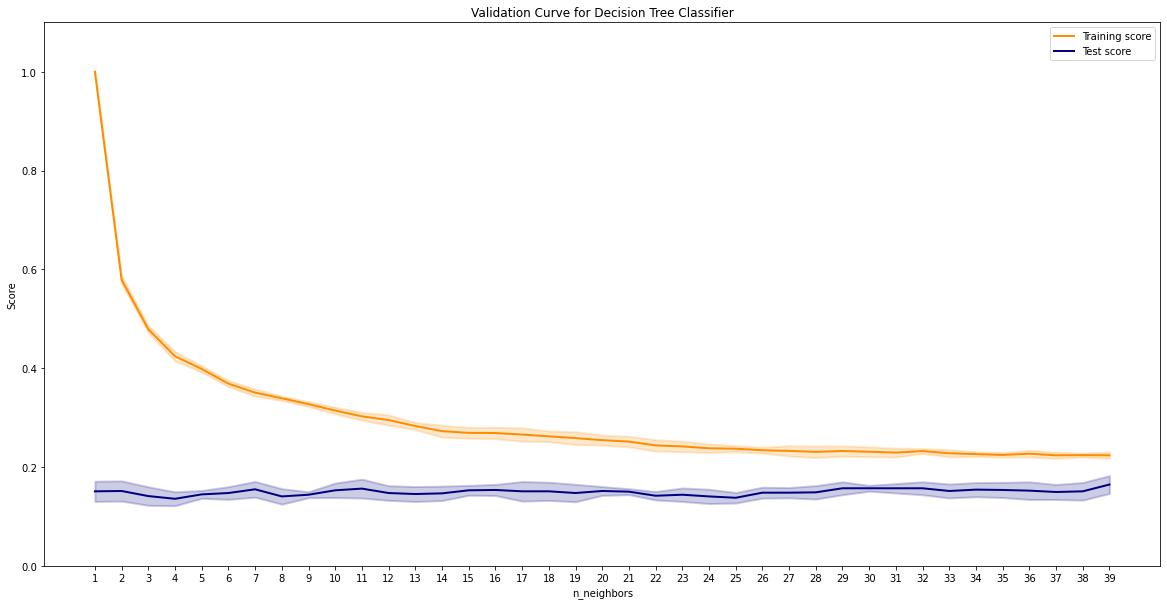

In [66]:
df_encoded = encode_df(df_downsampled, LabelEncoder().fit(df_downsampled.decade), LabelEncoder().fit(df_downsampled.genre))
X_train, X_test, y_train, y_test = split(df_encoded)
plot_validation_curve(KNeighborsClassifier(),
                      df_encoded.drop(['n_genre'], axis=1),
                      df_encoded['n_genre'],
                      param_name='n_neighbors',
                      param_range=list(range(1, 40)),
                      cv=5)

#### Scaled

In [62]:
df_downsampled_scaled = scale_df(df_downsampled, StandardScaler())

Model accuracy score: 0.4986301369863014
DummyClassifier accuracy score: 0.07671232876712329
Confusion matrix: 
[[22  2  2  0  0  0  0  2  0]
 [12 30  2  2  0  0  3  3  0]
 [ 5  1 28  3  0  0  3  2  4]
 [ 0  4  3 25  0  1  0  2  1]
 [13  4  4  0 11  0  1  2  1]
 [ 0  6  0  0  0 25  1  7  0]
 [ 6  8  7  4  1  1  3  8  2]
 [ 3  6  7  1  2  3  4 18  1]
 [ 0  3  6  2  0  7  2  3 20]]
Classification report: 
              precision    recall  f1-score   support

           0       0.36      0.79      0.49        28
           1       0.47      0.58      0.52        52
           2       0.47      0.61      0.53        46
           3       0.68      0.69      0.68        36
           4       0.79      0.31      0.44        36
           5       0.68      0.64      0.66        39
           6       0.18      0.07      0.11        40
           7       0.38      0.40      0.39        45
           8       0.69      0.47      0.56        43

    accuracy                           0.50       3

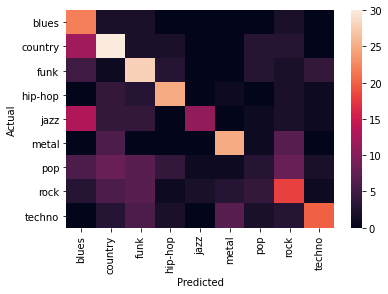

In [63]:
knn_classifier = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 40)}
knn_gscv = GridSearchCV(knn_classifier, param_grid, cv=5)
fit_summary(knn_gscv, df_downsampled_scaled)

In [64]:
knn_gscv.best_params_

{'n_neighbors': 26}

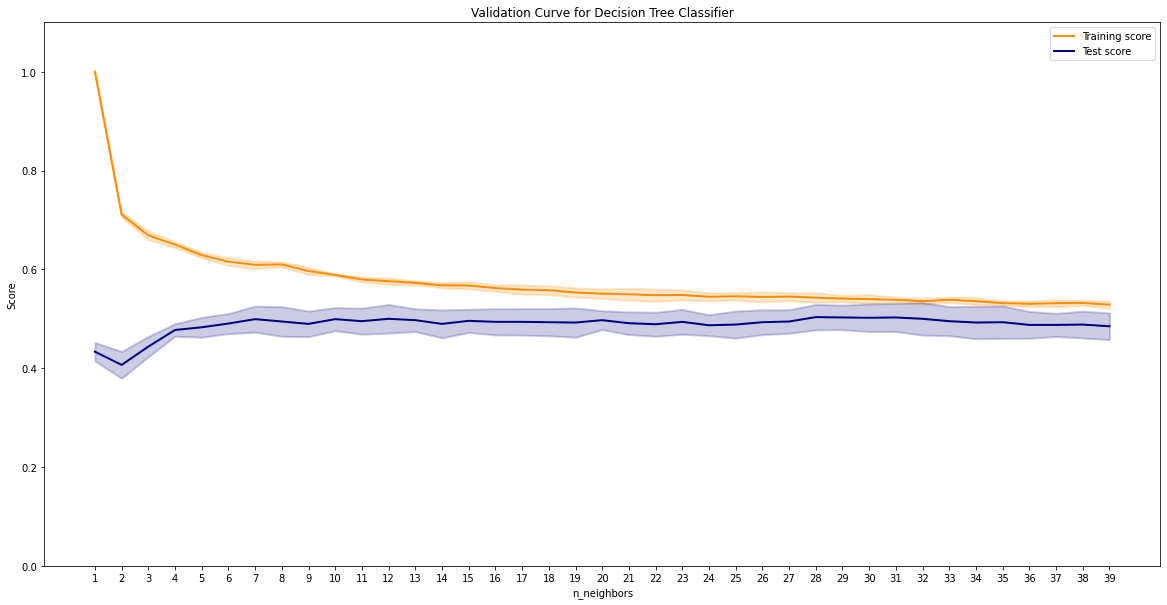

In [65]:
df_encoded = encode_df(df_downsampled_scaled, LabelEncoder().fit(df_downsampled_scaled.decade), LabelEncoder().fit(df_downsampled_scaled.genre))
X_train, X_test, y_train, y_test = split(df_encoded)
plot_validation_curve(KNeighborsClassifier(),
                      df_encoded.drop(['n_genre'], axis=1),
                      df_encoded['n_genre'],
                      param_name='n_neighbors',
                      param_range=list(range(1, 40)),
                      cv=5)

## Regression

### Imports

In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

### Pairplots

A full pairplot between all continous features can be found in `visualize.ipynb`

Energy and loudness are selected because they show a relatively high correlation in the data

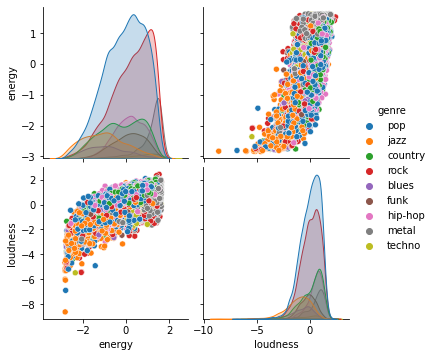

In [68]:
sns.pairplot(df_scaled[['energy', 'loudness', 'genre']], hue='genre')

### Model

In [69]:
X_set = df_encoded[['energy']]
y_set = df_encoded['loudness']
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set)

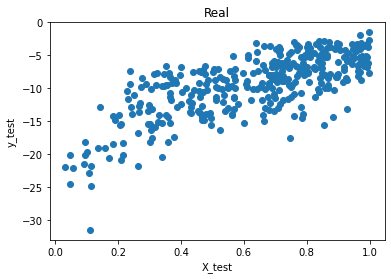

In [87]:
plt.title('Real')
plt.xlabel('X_test')
plt.ylabel('y_test')
plt.scatter(X_test, y_test)

In [83]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
y_pred = knn_reg.predict(X_test)

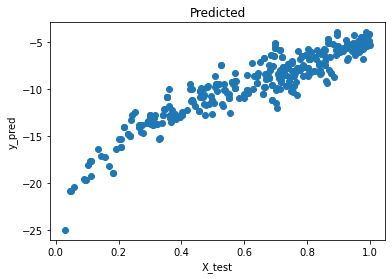

In [88]:
plt.title('Predicted')
plt.xlabel('X_test')
plt.ylabel('y_pred')
plt.scatter(X_test, y_pred)

In [89]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2 score: {r2_score(y_test, y_pred)}')

MSE: 11.024975894027397
R2 score: 0.49394011443790675
